**Menginstall Library yang diperlukan**


In [ ]:
!pip install spacy
!pip install nltk
! pip install pandas
!pip install SpacyTextBlob
!pip install spacy-lookups-data
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: textblob
    Found existing installation: textblob 0.17.1
    Uninstalling textblob-0.17.1:
      Successfully uninstalled textblob-0.17.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 7.9 MB/s eta 0:00:00


**Mengambil data yang diperlukan dari google drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
input_data=('/content/drive/MyDrive/ProyekAI/input/tapera.csv')
cleaned_tweets=('output/cleaned_tweets.csv')
slang_dictionary=('/content/drive/MyDrive/ProyekAI/dictionary/colloquial-indonesian-lexicon.csv')
inset_neg=('/content/drive/MyDrive/ProyekAI/lexicon/inset/_json_inset-neg.txt')
inset_pos=('/content/drive/MyDrive/ProyekAI/lexicon/inset/_json_inset-pos.txt')


**Melakukan filtering dengan menghapus simbol serta huruf yang diulang 3kali (contoh : tidakkk)**

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import csv
import re



df=pd.read_csv(input_data)
def clean_tweet(tweet):
    cleaned_tweet = ' '.join(re.sub(r"(@[A-Za-z0-9_]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet.lower()).split())

    # Reduce redundant letters
    cleaned_tweet = re.sub(r'([a-zA-Z])\1\1+', r'\1\1', cleaned_tweet)

    return cleaned_tweet


df.to_csv(cleaned_tweets,index=False)


df=pd.read_csv(cleaned_tweets)

df['full_text']=df['full_text'].apply(clean_tweet)
df.to_csv(cleaned_tweets,index=False,quoting=csv.QUOTE_ALL)





**Menerjemahkan bahasa slang dan singkatan menggunakan kamus-allay**


 Github : https://github.com/nasalsabila/kamus-alay

In [ ]:
import pandas as pd
import re
import csv
import spacy
import time

df=pd.read_csv(slang_dictionary)




slang_dict=pd.Series(df.formal.values, index=df.slang).to_dict()


def translate_slang(text):
    words=text.split()
    translated_words=[slang_dict[word.lower()] if word.lower() in slang_dict else word for word in words]
    translated_text = ' '.join(translated_words)
    return translated_text












df=pd.read_csv('output/cleaned_tweets.csv')
df['full_text']=df['full_text'].apply(translate_slang)
df.to_csv(cleaned_tweets,index=False, quoting=csv.QUOTE_ALL)



**Melakukan Lemmatisasi dan menghapus tweet duplikat**


In [ ]:

from spacytextblob.spacytextblob import SpacyTextBlob
import pandas as pd
import re
import csv
import spacy
from spacy.lang.id import Indonesian
from spacy.lookups import load_lookups


nlp = spacy.blank('id')
nlp.add_pipe('lemmatizer',config={"mode":"lookup"})
nlp.initialize()

def lemmatize(text):
    lemmas=[]
    doc =nlp(text)
    for token in doc:
        if( not token.is_punct and not token.is_stop):
            lemmas.append(token.lemma_)

    return ' '.join(lemmas)


df=pd.read_csv(cleaned_tweets)

df['full_text']=df['full_text'].apply(lemmatize)
df.to_csv(cleaned_tweets, index=False, quoting=csv.QUOTE_ALL)









In [ ]:


df=pd.read_csv(cleaned_tweets)
df=df.drop_duplicates(subset=['full_text'], keep='first')

df.to_csv(cleaned_tweets,index=False, quoting=csv.QUOTE_ALL)

**Melakukan Labeling dengan menghitung sentimen tiap tweet menggunakan custom lexicon dari InSet**


Github : https://github.com/fajri91/InSet

In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
import pandas as pd
import csv

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import json
import reprlib


custom_lexicon=SentimentIntensityAnalyzer()
lexicon1A=SentimentIntensityAnalyzer()
lexicon1B=SentimentIntensityAnalyzer()
lexicon2=SentimentIntensityAnalyzer()


with open(inset_neg) as f:
    dataLexicon1A=f.read()

with open(inset_pos) as f:
    dataLexicon1B=f.read()




insetNeg=json.loads(dataLexicon1A)
insetPos=json.loads(dataLexicon1B)



lexicon1A.lexicon.update(insetNeg)
lexicon1B.lexicon.update(insetPos)



def calculate_sentiment(text):

    text = str(text)
    return lexicon1A.polarity_scores(text)["compound"] + lexicon1B.polarity_scores(text)["compound"]



df=pd.read_csv(cleaned_tweets)
for index, row in df.iterrows():
    if pd.notna(row['full_text']):
        df.at[index, 'sentiment'] = str(calculate_sentiment(row['full_text']))
    else:
        df.at[index, 'sentiment'] = 'NaN'

df.to_csv(cleaned_tweets,index=False,quoting=csv.QUOTE_ALL)







**Melakukan Labeling Sentimen dengan melihat polarity sentimen tiap tweet**

In [ ]:
file_path = 'output/cleaned_tweets.csv'
df = pd.read_csv(file_path)

In [ ]:
def analyze_sentiment(sentiment_score):
    if sentiment_score > 0.0:
        return "positif"
    elif sentiment_score == 0.0:
        return "netral"
    else:
        return "negatif"

**Melakukan loop memasukkan data penting kedalam List**

In [ ]:
hasilAnalisis = []
for index, row in df.head(1159).iterrows():
    tweet_properties = {}
    tweet_properties["tanggal_tweet"] = row['created_at']
    tweet_properties["pengguna"] = row['username']
    tweet_properties["isi_tweet"] = row['full_text']
    tweet_properties["sentimen"] = analyze_sentiment(row['sentiment'])

    hasilAnalisis.append(tweet_properties)

**Mengecek apakah data telah berhasil dimasukkan kedalam List**

In [ ]:
for tweet in hasilAnalisis:
    print("Tanggal Tweet:", tweet["tanggal_tweet"])
    print("Pengguna:", tweet["pengguna"])
    print("Isi Tweet:", tweet["isi_tweet"])
    print("Sentimen:", tweet["sentimen"])
    print("-----------------------")

Streaming output truncated to the last 5000 lines.
Tanggal Tweet: Mon Jun 17 05:37:29 +0000 2024
Pengguna: pray4ky
Isi Tweet: isyell khodam diskon tapera
Sentimen: positif
-----------------------
Tanggal Tweet: Mon Jun 17 05:34:42 +0000 2024
Pengguna: rskuntowiyoga
Isi Tweet: judi online legal 30 masuk pajak kelar ikn sok sok udunan pakai tapera
Sentimen: positif
-----------------------
Tanggal Tweet: Mon Jun 17 05:32:36 +0000 2024
Pengguna: TaraMalika123
Isi Tweet: dana tapera uang muka kpr terima manfaat bkl tingkat akses kpr tingkat stabilitas industri sektor properti rumah bcoz dana tapera sedia sumber dana dana jangka
Sentimen: positif
-----------------------
Tanggal Tweet: Mon Jun 17 05:32:31 +0000 2024
Pengguna: IrfanJaya09
Isi Tweet: dana tapera uang muka kpr terima manfaat tingkat akses kpr tingkat stabilitas industri sektor properti rumah dana tapera sedia sumber dana dana jangka
Sentimen: positif
-----------------------
Tanggal Tweet: Mon Jun 17 05:32:17 +0000 2024
Pengguna:

**Melakukan loop memasukkan data sentimen kedalam List berdasarkan positif, negatif, dan netral. dan menghitung data sentimen**

In [ ]:
tweet_positif = [t for t in hasilAnalisis if t["sentimen"] == "positif"]
tweet_netral = [t for t in hasilAnalisis if t["sentimen"] == "netral"]
tweet_negatif = [t for t in hasilAnalisis if t["sentimen"] == "negatif"]

In [ ]:
total_tweets = len(hasilAnalisis)
percent_positif = 100 * len(tweet_positif) / total_tweets
percent_netral = 100 * len(tweet_netral) / total_tweets
percent_negatif = 100 * len(tweet_negatif) / total_tweets

**Mengubah angka dari data hasil penjumlahan sentimen menjadi persen**

In [ ]:
print("Hasil Sentimen")
print("Positif: ", len(tweet_positif), "({:.2f} %)".format(percent_positif))
print("Netral: ", len(tweet_netral), "({:.2f} %)".format(percent_netral))
print("Negatif: ", len(tweet_negatif), "({:.2f} %)".format(percent_negatif))

Hasil Sentimen
Positif:  328 (28.32 %)
Netral:  169 (14.59 %)
Negatif:  661 (57.08 %)


**Membuat pie chart dari data hasil sentimen yang telah dilakukan**

In [ ]:
!pip install matplotlib

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
labels = 'Positif', 'Netral', 'Negatif'
sizes = [percent_positif, percent_netral, percent_negatif]
colors = ['blue', 'gray', 'red']
explode = (0.1, 0, 0)

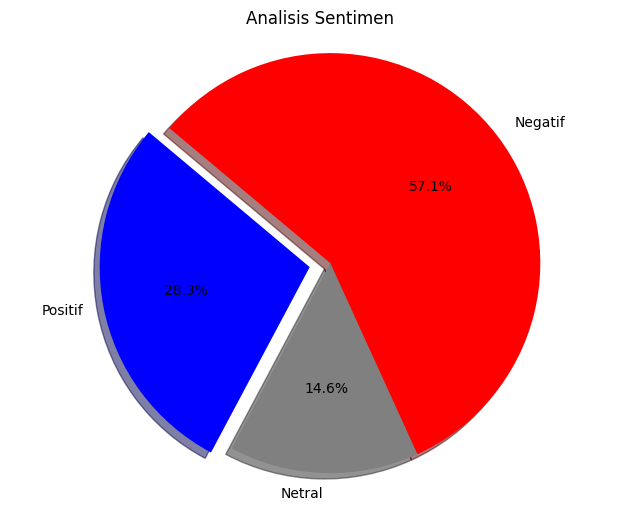

In [ ]:
plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Analisis Sentimen')
plt.show()